In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.utils.data import DataLoader

torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

# fix seed
np.random.seed(0)

## Data

In [3]:
# means and standard deviations ImageNet because the network is pretrained
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# Define transforms to apply to each image
transf = transforms.Compose(
    [  # transforms.Resize(227),      # Resizes short size of the PIL image to 256
        transforms.CenterCrop(
            224
        ),  # Crops a central square patch of the image 224 because torchvision's AlexNet needs a 224x224 input!
        transforms.ToTensor(),  # Turn PIL Image to torch.Tensor
        transforms.Normalize(
            means, stds
        ),  # Normalizes tensor with mean and standard deviation
    ]
)

In [4]:
# Clone github repository with data
if not os.path.isdir("./Homework3-PACS"):
    !git clone https://github.com/MachineLearning2020/Homework3-PACS

# Define datasets root
DIR_PHOTO = "Homework3-PACS/PACS/photo"
DIR_ART = "Homework3-PACS/PACS/art_painting"
DIR_CARTOON = "Homework3-PACS/PACS/cartoon"
DIR_SKETCH = "Homework3-PACS/PACS/sketch"

# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO, transform=transf)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART, transform=transf)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON, transform=transf)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH, transform=transf)

# Check dataset sizes
print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [5]:
# Split dataset into train and test
train_size = int(0.8 * len(photo_dataset))
test_size = len(photo_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    photo_dataset, [train_size, test_size]
)

In [6]:
# Concatenate all datasets
test_datasets = torch.utils.data.ConcatDataset([test_dataset, sketch_dataset])

# Create Dataloaders
trainloader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True
)
testloader = DataLoader(test_datasets, batch_size=128, shuffle=False, num_workers=4)

In [7]:
print(f"Train batches: {len(trainloader)}")
print(f"Test batches: {len(testloader)}")

Train batches: 10
Test batches: 34


## Model

In [8]:
from torchvision.models import mobilenet_v3_small


class Model(nn.Module):
    def __init__(self, num_classes=2):
        super(Model, self).__init__()
        self.backbone = mobilenet_v3_small(pretrained=True)
        self.backbone.classifier = nn.Sequential()

        self.head = nn.Linear(576, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [9]:
model = Model(num_classes=7).to(device)

/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [11]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            # loss
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [12]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 50

In [13]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0  # to track number of correct predictions
    total = 0  # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # loss
        loss = criterion(outputs, labels)

        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(
        f"Epoch [{(epoch + 1):2}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.3f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%"
    )

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [ 1/ 50] 	 Loss: 1.77451     Accuracy: 43.828% 	 Test Loss: 2.00640     Test Accuracy: 7.69%
Epoch [ 2/ 50] 	 Loss: 1.41336     Accuracy: 66.406% 	 Test Loss: 1.96339     Test Accuracy: 8.16%
Epoch [ 3/ 50] 	 Loss: 1.13279     Accuracy: 77.109% 	 Test Loss: 1.93015     Test Accuracy: 10.91%
Epoch [ 4/ 50] 	 Loss: 0.91835     Accuracy: 86.875% 	 Test Loss: 1.91039     Test Accuracy: 17.05%
Epoch [ 5/ 50] 	 Loss: 0.76410     Accuracy: 92.266% 	 Test Loss: 1.90219     Test Accuracy: 20.31%
Epoch [ 6/ 50] 	 Loss: 0.62262     Accuracy: 94.766% 	 Test Loss: 1.92632     Test Accuracy: 20.97%
Epoch [ 7/ 50] 	 Loss: 0.49577     Accuracy: 95.859% 	 Test Loss: 2.00572     Test Accuracy: 21.23%
Epoch [ 8/ 50] 	 Loss: 0.38040     Accuracy: 96.094% 	 Test Loss: 2.23830     Test Accuracy: 21.37%
Epoch [ 9/ 50] 	 Loss: 0.30184     Accuracy: 97.188% 	 Test Loss: 2.54637     Test Accuracy: 21.53%
Epoch [10/ 50] 	 Loss: 0.24016     Accuracy: 97.109% 	 Test Loss: 2.73921     Test Accuracy: 21.75%
Ep

In [14]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(
    f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%"
)


Best epoch: 16 with test accuracy: 22.12%


# Plot results

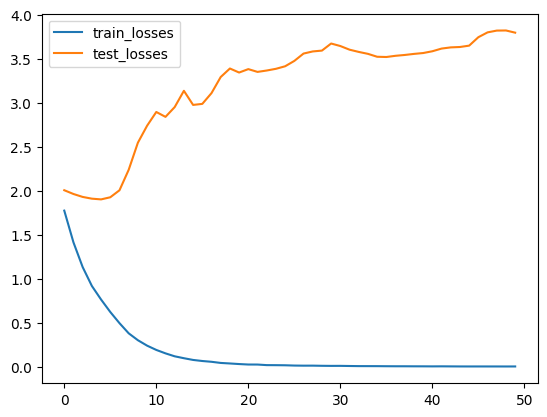

In [15]:
plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()

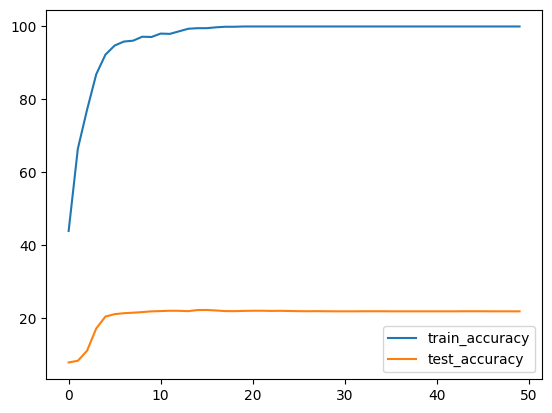

In [16]:
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(test_accuracies, label="test_accuracy")
plt.legend()